In [131]:
%%capture

!pip install ultralytics
!pip install shapely

#install important packages

In [132]:
from ultralytics import YOLO

from matplotlib.pyplot import figure
import matplotlib.image as image
from matplotlib import pyplot as plt


import pandas as pd
import numpy as np
from numpy import asarray
from PIL import Image

import cv2

from shapely.geometry import Polygon


In [133]:
def order_points(pts):
    
    # order a list of 4 coordinates:
    # 0: top-left,
    # 1: top-right
    # 2: bottom-right,
    # 3: bottom-left

    print("pts", pts)
    
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    print("rect", rect)
    
    return rect

In [134]:
# calculates iou between two polygons

def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou

In [135]:
def detect_corners(image_filename, show_image = False):
    """
    Detects the corners of a given image. Set show_image to True to display the image with corners and intersections marked.
    """
    
    # # YOLO model trained to detect corners on a chessboard
    # model_trained = YOLO("best_corners.pt")
    # results = model_trained.predict(source=image, line_thickness=1, conf=0.25, save_txt=True, save=True)

    # # get the corners coordinates from the model
    # boxes = results[0].boxes
    # arr = boxes.xywh.numpy()
    # points = arr[:,0:2]
    
    # corners = order_points(points)

    import cv2
    import math
    img = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (350, 350))
    # cv2.imwrite(image_filename, img_resized)

    GRID = (7, 7)

    found, corners = cv2.findChessboardCornersSB(
        img_resized, GRID, cv2.CALIB_CB_ADAPTIVE_THRESH)

    corner1 = corners[0] - (corners[1] - corners[0]) - (corners[7] - corners[0])
    corner2 = corners[6] + (corners[6] - corners[5]) - (corners[13] - corners[6])
    corner3 = corners[42] - (corners[43] - corners[42]) + (corners[42] - corners[35])
    corner4 = corners[48] + (corners[48] - corners[47]) + (corners[48] - corners[41])

    if show_image:
        cv2.drawChessboardCorners(img_resized, GRID, corners, found)
        for i, corner in enumerate([corner1, corner2, corner3, corner4]):
            print(corner[0][0])
            img_resized = cv2.circle(img_resized, (math.floor(corner[0][0]), math.floor(corner[0][1])), radius = 5, color = (255*i/4,255*i/4,255*i/4))
        cv2.imshow('img_captured_corners', img_resized)
        cv2.waitKey(0)
    
    return order_points(np.array([corner1[0], corner2[0], corner3[0], corner4[0]]))

In [136]:
# perspective transforms an image with four given corners

def four_point_transform(image, pts):
      
    img = Image.open(image)
    image = asarray(img)
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
   

    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # construct set of destination points to obtain a "birds eye view"
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    img = Image.fromarray(warped, "RGB")
    # img.show()    
    # return the warped image
    return img

In [137]:
# calculates chessboard grid

def plot_grid_on_transformed_image(image):
    
    corners = np.array([[0,0], 
                    [image.size[0], 0], 
                    [0, image.size[1]], 
                    [image.size[0], image.size[1]]])
    
    corners = order_points(corners)

    figure(figsize=(10, 10), dpi=80)

    # im = plt.imread(image)
    implot = plt.imshow(image)
    
    TL = corners[0]
    BL = corners[3]
    TR = corners[1]
    BR = corners[2]

    def interpolate(xy0, xy1):
        x0,y0 = xy0
        x1,y1 = xy1
        dx = (x1-x0) / 8
        dy = (y1-y0) / 8
        pts = [(x0+i*dx,y0+i*dy) for i in range(9)]
        return pts

    ptsT = interpolate( TL, TR )
    ptsL = interpolate( TL, BL )
    ptsR = interpolate( TR, BR )
    ptsB = interpolate( BL, BR )
        
    for a,b in zip(ptsL, ptsR):
        plt.plot( [a[0], b[0]], [a[1], b[1]], 'ro', linestyle="--" )
    for a,b in zip(ptsT, ptsB):
        plt.plot( [a[0], b[0]], [a[1], b[1]], 'ro', linestyle="--" )
        
    plt.axis('off')

    plt.savefig('chessboard_transformed_with_grid.jpg')
    return ptsT, ptsL

In [138]:
# detects chess pieces

def chess_pieces_detector(image):
    
    model_trained = YOLO("best_transformed_detection.pt")
    results = model_trained.predict(source=image, line_thickness=1, conf=0.5, augment=False, save_txt=True, save=True)
    
    boxes = results[0].boxes
    detections = boxes.xyxy.numpy()
    
    return detections, boxes

In [139]:
# connects detected piece to the right square

def connect_square_to_detection(detections, square):
    
    di = {0: 'b', 1: 'k', 2: 'n',
      3: 'p', 4: 'q', 5: 'r', 
      6: 'B', 7: 'K', 8: 'N',
      9: 'P', 10: 'Q', 11: 'R'}

    list_of_iou=[]
    
    for i in detections:

        box_x1 = i[0]
        box_y1 = i[1]

        box_x2 = i[2]
        box_y2 = i[1]

        box_x3 = i[2]
        box_y3 = i[3]

        box_x4 = i[0]
        box_y4 = i[3]
        
        #cut high pieces        
        if box_y4 - box_y1 > 60:
            box_complete = np.array([[box_x1,box_y1+40], [box_x2, box_y2+40], [box_x3, box_y3], [box_x4, box_y4]])
        else:
            box_complete = np.array([[box_x1,box_y1], [box_x2, box_y2], [box_x3, box_y3], [box_x4, box_y4]])
            
        #until here

        list_of_iou.append(calculate_iou(box_complete, square))

    num = list_of_iou.index(max(list_of_iou))

    piece = boxes.cls[num].tolist()
    
    if max(list_of_iou) > 0.15:
        piece = boxes.cls[num].tolist()
        return di[piece]
    
    else:
        piece = "empty"
        return piece

## Complete

pts [[     95.979      88.311]
 [     284.94      97.732]
 [     41.546      223.48]
 [     290.94      242.08]]
rect [[     95.979      88.311]
 [     284.94      97.732]
 [     290.94      242.08]
 [     41.546      223.48]]
corners [[     95.979      88.311]
 [     284.94      97.732]
 [     290.94      242.08]
 [     41.546      223.48]]
pts [[     95.979      88.311]
 [     284.94      97.732]
 [     290.94      242.08]
 [     41.546      223.48]]
rect [[     95.979      88.311]
 [     284.94      97.732]
 [     290.94      242.08]
 [     41.546      223.48]]


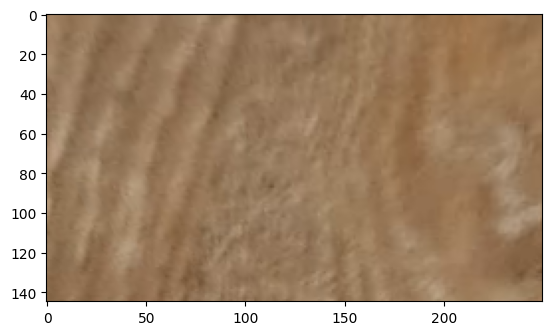

pts [[  0   0]
 [250   0]
 [  0 145]
 [250 145]]
rect [[          0           0]
 [        250           0]
 [        250         145]
 [          0         145]]


FileNotFoundError: [Errno 2] No such file or directory: 'best_transformed_detection.pt'

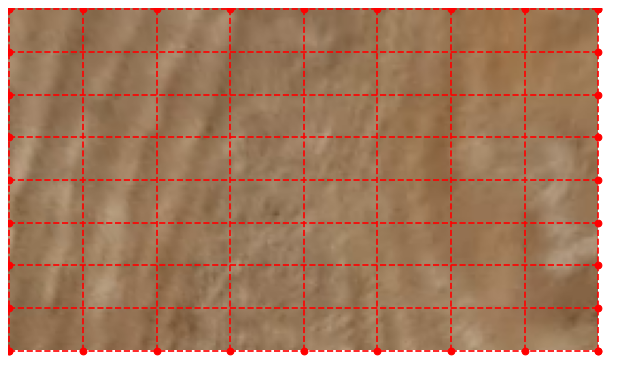

In [140]:
import numpy as np

image = 'images/test2.jpeg'

corners = detect_corners(image)

print("corners", corners)

transformed_image = four_point_transform(image, corners)

plt.imshow(transformed_image)
plt.show()

ptsT, ptsL = plot_grid_on_transformed_image(transformed_image)

detections, boxes = chess_pieces_detector(transformed_image)

#calculate the grid

xA = ptsT[0][0]
xB = ptsT[1][0]
xC = ptsT[2][0]
xD = ptsT[3][0]
xE = ptsT[4][0]
xF = ptsT[5][0]
xG = ptsT[6][0]
xH = ptsT[7][0]
xI = ptsT[8][0]

y9 = ptsL[0][1]
y8 = ptsL[1][1] 
y7 = ptsL[2][1] 
y6 = ptsL[3][1]  
y5 = ptsL[4][1]  
y4 = ptsL[5][1] 
y3 = ptsL[6][1]  
y2 = ptsL[7][1] 
y1 = ptsL[8][1] 

#calculate all the squares

a8 = np.array([[xA,y9], [xB, y9], [xB, y8], [xA, y8]])
a7 = np.array([[xA,y8], [xB, y8], [xB, y7], [xA, y7]])
a6 = np.array([[xA,y7], [xB, y7], [xB, y6], [xA, y6]])
a5 = np.array([[xA,y6], [xB, y6], [xB, y5], [xA, y5]])
a4 = np.array([[xA,y5], [xB, y5], [xB, y4], [xA, y4]])
a3 = np.array([[xA,y4], [xB, y4], [xB, y3], [xA, y3]])
a2 = np.array([[xA,y3], [xB, y3], [xB, y2], [xA, y2]])
a1 = np.array([[xA,y2], [xB, y2], [xB, y1], [xA, y1]])

b8 = np.array([[xB,y9], [xC, y9], [xC, y8], [xB, y8]])
b7 = np.array([[xB,y8], [xC, y8], [xC, y7], [xB, y7]])
b6 = np.array([[xB,y7], [xC, y7], [xC, y6], [xB, y6]])
b5 = np.array([[xB,y6], [xC, y6], [xC, y5], [xB, y5]])
b4 = np.array([[xB,y5], [xC, y5], [xC, y4], [xB, y4]])
b3 = np.array([[xB,y4], [xC, y4], [xC, y3], [xB, y3]])
b2 = np.array([[xB,y3], [xC, y3], [xC, y2], [xB, y2]])
b1 = np.array([[xB,y2], [xC, y2], [xC, y1], [xB, y1]])

c8 = np.array([[xC,y9], [xD, y9], [xD, y8], [xC, y8]])
c7 = np.array([[xC,y8], [xD, y8], [xD, y7], [xC, y7]])
c6 = np.array([[xC,y7], [xD, y7], [xD, y6], [xC, y6]])
c5 = np.array([[xC,y6], [xD, y6], [xD, y5], [xC, y5]])
c4 = np.array([[xC,y5], [xD, y5], [xD, y4], [xC, y4]])
c3 = np.array([[xC,y4], [xD, y4], [xD, y3], [xC, y3]])
c2 = np.array([[xC,y3], [xD, y3], [xD, y2], [xC, y2]])
c1 = np.array([[xC,y2], [xD, y2], [xD, y1], [xC, y1]])

d8 = np.array([[xD,y9], [xE, y9], [xE, y8], [xD, y8]])
d7 = np.array([[xD,y8], [xE, y8], [xE, y7], [xD, y7]])
d6 = np.array([[xD,y7], [xE, y7], [xE, y6], [xD, y6]])
d5 = np.array([[xD,y6], [xE, y6], [xE, y5], [xD, y5]])
d4 = np.array([[xD,y5], [xE, y5], [xE, y4], [xD, y4]])
d3 = np.array([[xD,y4], [xE, y4], [xE, y3], [xD, y3]])
d2 = np.array([[xD,y3], [xE, y3], [xE, y2], [xD, y2]])
d1 = np.array([[xD,y2], [xE, y2], [xE, y1], [xD, y1]])

e8 = np.array([[xE,y9], [xF, y9], [xF, y8], [xE, y8]])
e7 = np.array([[xE,y8], [xF, y8], [xF, y7], [xE, y7]])
e6 = np.array([[xE,y7], [xF, y7], [xF, y6], [xE, y6]])
e5 = np.array([[xE,y6], [xF, y6], [xF, y5], [xE, y5]])
e4 = np.array([[xE,y5], [xF, y5], [xF, y4], [xE, y4]])
e3 = np.array([[xE,y4], [xF, y4], [xF, y3], [xE, y3]])
e2 = np.array([[xE,y3], [xF, y3], [xF, y2], [xE, y2]])
e1 = np.array([[xE,y2], [xF, y2], [xF, y1], [xE, y1]])

f8 = np.array([[xF,y9], [xG, y9], [xG, y8], [xF, y8]])
f7 = np.array([[xF,y8], [xG, y8], [xG, y7], [xF, y7]])
f6 = np.array([[xF,y7], [xG, y7], [xG, y6], [xF, y6]])
f5 = np.array([[xF,y6], [xG, y6], [xG, y5], [xF, y5]])
f4 = np.array([[xF,y5], [xG, y5], [xG, y4], [xF, y4]])
f3 = np.array([[xF,y4], [xG, y4], [xG, y3], [xF, y3]])
f2 = np.array([[xF,y3], [xG, y3], [xG, y2], [xF, y2]])
f1 = np.array([[xF,y2], [xG, y2], [xG, y1], [xF, y1]])

g8 = np.array([[xG,y9], [xH, y9], [xH, y8], [xG, y8]])
g7 = np.array([[xG,y8], [xH, y8], [xH, y7], [xG, y7]])
g6 = np.array([[xG,y7], [xH, y7], [xH, y6], [xG, y6]])
g5 = np.array([[xG,y6], [xH, y6], [xH, y5], [xG, y5]])
g4 = np.array([[xG,y5], [xH, y5], [xH, y4], [xG, y4]])
g3 = np.array([[xG,y4], [xH, y4], [xH, y3], [xG, y3]])
g2 = np.array([[xG,y3], [xH, y3], [xH, y2], [xG, y2]])
g1 = np.array([[xG,y2], [xH, y2], [xH, y1], [xG, y1]])

h8 = np.array([[xH,y9], [xI, y9], [xI, y8], [xH, y8]])
h7 = np.array([[xH,y8], [xI, y8], [xI, y7], [xH, y7]])
h6 = np.array([[xH,y7], [xI, y7], [xI, y6], [xH, y6]])
h5 = np.array([[xH,y6], [xI, y6], [xI, y5], [xH, y5]])
h4 = np.array([[xH,y5], [xI, y5], [xI, y4], [xH, y4]])
h3 = np.array([[xH,y4], [xI, y4], [xI, y3], [xH, y3]])
h2 = np.array([[xH,y3], [xI, y3], [xI, y2], [xH, y2]])
h1 = np.array([[xH,y2], [xI, y2], [xI, y1], [xH, y1]])

# transforms the squares to write FEN

FEN_annotation = [[a8, b8, c8, d8, e8, f8, g8, h8],
                [a7, b7, c7, d7, e7, f7, g7, h7],
                [a6, b6, c6, d6, e6, f6, g6, h6],
                [a5, b5, c5, d5, e5, f5, g5, h5],
                [a4, b4, c4, d4, e4, f4, g4, h4],
                [a3, b3, c3, d3, e3, f3, g3, h3],
                [a2, b2, c2, d2, e2, f2, g2, h2],
                [a1, b1, c1, d1, e1, f1, g1, h1]]

board_FEN = []
corrected_FEN = []
complete_board_FEN = []

for line in FEN_annotation:
    line_to_FEN = []
    for square in line:
        piece_on_square = connect_square_to_detection(detections, square)    
        line_to_FEN.append(piece_on_square)
    corrected_FEN = [i.replace('empty', '1') for i in line_to_FEN]
    print(corrected_FEN)
    board_FEN.append(corrected_FEN)

complete_board_FEN = [''.join(line) for line in board_FEN] 

to_FEN = '/'.join(complete_board_FEN)

print("https://lichess.org/analysis/"+to_FEN)